In [1]:
import cv2
import mediapipe as mp

In [38]:
import cv2
import mediapipe as mp
import numpy as np
import time, os, sys

actions = ['egg clap', 'wrist clap', 'fist clap', 'edge clap']
seq_length = 20 # 웹 크기
secs_for_action = 30 # 데이터 수집 시간 (초)

# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=2,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.3)

cap = cv2.VideoCapture(0)

created_time = int(time.time())
os.makedirs('dataset', exist_ok=True)

while cap.isOpened():
    for idx, action in enumerate(actions):
        if(idx == 4): break
        data = []

        ret, img = cap.read()

        img = cv2.flip(img, 1)

        cv2.putText(img, f'Waiting for collecting {action.upper()} action...', org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        cv2.imshow('img', img)
        cv2.waitKey(3000)

        start_time = time.time()

        while time.time() - start_time < secs_for_action:
            ret, img = cap.read()

            img = cv2.flip(img, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = hands.process(img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            if result.multi_hand_landmarks is not None:
                for res in result.multi_hand_landmarks:
                    joint = np.zeros((21, 4))
                    for j, lm in enumerate(res.landmark):
                        joint[j] = [lm.x, lm.y, lm.z, lm.visibility] # visibility는 손가락이 보이는지 안 보이는지 확인

                    # Compute angles between joints
                    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                    v = v2 - v1 # [20, 3]
                    # Normalize v
                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                    # Get angle using arcos of dot product
                    angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                    angle = np.degrees(angle) # Convert radian to degree

                    angle_label = np.array([angle], dtype=np.float32)
                    angle_label = np.append(angle_label, idx)

                    d = np.concatenate([joint.flatten(), angle_label])

                    data.append(d)

                    mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            cv2.imshow('img', img)
            if cv2.waitKey(1) == ord('q'):
                break

        data = np.array(data)
        print(action, data.shape)
        np.save(os.path.join('dataset', f'raw_{action}_{created_time}'), data)

        # Create sequence data
        full_seq_data = []
        for seq in range(len(data) - seq_length):
            full_seq_data.append(data[seq:seq + seq_length])

        full_seq_data = np.array(full_seq_data)
        print(action, full_seq_data.shape)
        np.save(os.path.join('dataset', f'seq_{action}_{created_time}'), full_seq_data)

    time.sleep(10)  # 파일 크기가 커질 경우 time.sleep 기간을 더 크게 설정 (현재는 30s)
    cap.release()
cv2.destroyAllWindows()



egg clap (1377, 100)
egg clap (1357, 20, 100)
wrist clap (1430, 100)
wrist clap (1410, 20, 100)
fist clap (1405, 100)
fist clap (1385, 20, 100)
edge clap (1432, 100)
edge clap (1412, 20, 100)


In [2]:
import numpy as np
import os

# TensorFlow가 실행될 때 이를 참조하여 GPU 사용 및 메모리 할당을 제어
# 메모리 최적화를 위해 사용
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
actions = [
    'egg clap',
    'wrist clap',
    'fist clap',
    'edge clap'
]

data = np.concatenate([
    np.load('seq_edge clap_1714908984.npy'),
    np.load('seq_egg clap_1714908984.npy'),
    np.load('seq_fist clap_1714908984.npy'),
    np.load('seq_wrist clap_1714908984.npy')
], axis=0)

data.shape

(5564, 20, 100)

In [5]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(5564, 20, 99)
(5564,)


In [6]:
from keras.utils import to_categorical

# 원핫인코딩 실행
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(5564, 4)

In [7]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# 10%를 test_set
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5007, 20, 99) (5007, 4)
(557, 20, 99) (557, 4)


In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 44196 (172.64 KB)
Trainable params: 44196 (172.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=150,
    callbacks=[
        ModelCheckpoint('models/model2.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/150


155/157 [============================>.] - ETA: 0s - loss: 3.0974 - acc: 0.8823
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models\model2.keras
157/157 [==============================] - 3s 8ms/step - loss: 3.0683 - acc: 0.8834 - val_loss: 1.1358e-04 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/150
156/157 [============================>.] - ETA: 0s - loss: 6.4025e-05 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
157/157 [==============================] - 1s 7ms/step - loss: 6.3863e-05 - acc: 1.0000 - val_loss: 3.5479e-05 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/150
157/157 [==============================] - ETA: 0s - loss: 2.4115e-05 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
157/157 [==============================] - 1s 7ms/step - loss: 2.4115e-05 - acc: 1.0000 - val_loss: 1.4758e-05 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/150
152/157 [============================>.] - ETA: 0s - loss: 1.1273e-05 - acc: 1.0000
Epoch 4: val_acc did

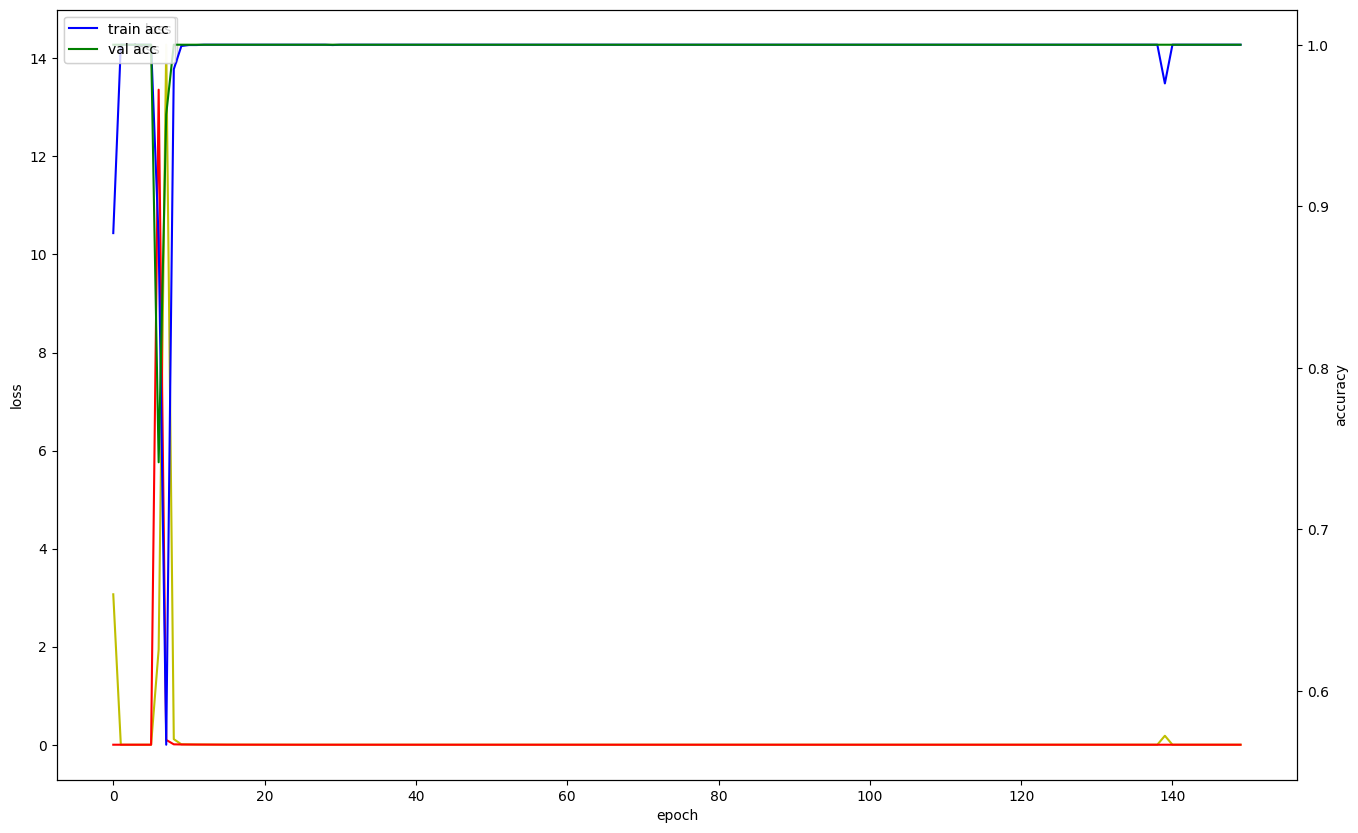

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [12]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model2.keras')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

18/18 [==============================] - 0s 3ms/step


array([[[427,   0],
        [  0, 130]],

       [[424,   0],
        [  0, 133]],

       [[400,   0],
        [  0, 157]],

       [[420,   0],
        [  0, 137]]], dtype=int64)

In [13]:
import cv2
import mediapipe as mp
import numpy as np
from keras.models import load_model

actions = ['egg clap', 'wrist clap', 'fist clap', 'edge clap']
seq_length = 20

model = load_model('models/model2.keras')

# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=2,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.3)

cap = cv2.VideoCapture(0)
win_w, win_h = cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

left_hand_seq = []  
right_hand_seq = []
action_seq = []

while cap.isOpened():
    ret, img = cap.read()
    img0 = img.copy()

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None:
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 4))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

            # Compute angles between joints
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
            v = v2 - v1 # [20, 3]
            # Normalize v
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # Convert radian to degree

            wrist_x = res.landmark[0].x * img.shape[1]  
            if wrist_x < img.shape[1] / 2:
                left_hand_position = wrist_x
                hand_side = "Left"
            else:
                right_hand_position = wrist_x
                hand_side = "Right"

            d = np.concatenate([joint.flatten(), angle])

            if wrist_x < img.shape[1] / 2:  
                left_hand_seq.append(d)  
            else:
                right_hand_seq.append(d)

            mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            if len(left_hand_seq) < seq_length or len(right_hand_seq) < seq_length:
                continue

            input_data_left = np.expand_dims(np.array(left_hand_seq[-seq_length:], dtype=np.float32), axis=0)
            input_data_right = np.expand_dims(np.array(right_hand_seq[-seq_length:], dtype=np.float32), axis=0)

            y_pred_left = model.predict(input_data_left).squeeze()
            y_pred_right = model.predict(input_data_right).squeeze()

            i_pred_left = int(np.argmax(y_pred_left))
            i_pred_right = int(np.argmax(y_pred_right))

            conf_left = y_pred_left[i_pred_left]
            conf_right = y_pred_right[i_pred_right]

            if conf_left < 0.8 or conf_right < 0.8:
                continue

            action_left = actions[i_pred_left]
            action_right = actions[i_pred_right]
            
            if right_hand_position - left_hand_position < 200:
                action = "actioning.."
                if action_left == action_right:
                    action = action_left
            else:
                action = "..."
                         
            cv2.putText(img, f'{action.upper()}', 
                        org=(int(win_w/2 - len(action.upper())*6), int(win_h/10)),  
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

    cv2.imshow('img', img)
    if cv2.waitKey(1) == ord('q'):
        cap.release()
cv2.destroyAllWindows()



c:\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 24ms/step
